The goal of this notebook is to perform a thorough analysis of training strategies and model assessment through cross-validation and train-val-test splitting, and boostrapping and bagging, random forest, linear regression, etc. It will also aid in visualizing model performance through learning curves, accuracy, and loss across training rounds.

In [1]:
##First load in the relevant files. These should be saved on your local host and downloded from the Google Drive in the README file.
# Install the necessary packages if you haven't already. 
#We will be working with only cloud brightness and shortwave radiation.

import xarray as xr

reflected_SW_radiation = xr.open_dataset("C:/Users/kathe/Downloads/ReflectedSW_remapped.nc")
cloud_optical_depth=xr.open_dataset("C:/Users/kathe/Downloads/CloudOpticalDepth_remapped.nc")
cloud_top_temperature=xr.open_dataset("C:/Users/kathe/Downloads/CloudTopTemperature_remapped.nc")
downward_SW_radiation=xr.open_dataset("C:/Users/kathe/Downloads/DownwardSW_remapped.nc")
total_precipitable_water=xr.open_dataset("C:/Users/kathe/Downloads/TotalPrecipWater_remapped.nc")
era5_meteorology=xr.open_dataset("C:/Users/kathe/Downloads/era5_data.nc")
era5_single_level=xr.open_dataset("C:/Users/kathe/Downloads/era5_single_levels.nc")




In [2]:
#Perform some basic functions to make sure the files have been loaded correctly. You should see the column names, etc. 

#Print a summary of each dataset
print("Shortwave Radiation Dataset:")
print(reflected_SW_radiation)
print("\nCloud Brightness Dataset:")
print(cloud_optical_depth)
print("\nCloud Top Temperature Dataset:")
print(cloud_top_temperature)
print("\nDownward Shortwave Radiation Dataset:")
print(downward_SW_radiation)
print("\nTotal Precipitable Water Dataset:")
print(total_precipitable_water)
print("\nERA5 Single Level Dataset:")
print(era5_single_level)

Shortwave Radiation Dataset:
<xarray.Dataset> Size: 798kB
Dimensions:      (time: 30, latitude: 41, longitude: 81)
Coordinates:
  * time         (time) int64 240B 92 93 94 95 96 97 ... 116 117 118 119 120 121
  * latitude     (latitude) float64 328B 20.0 20.25 20.5 ... 29.5 29.75 30.0
  * longitude    (longitude) float64 648B -65.0 -64.75 -64.5 ... -45.25 -45.0
Data variables:
    ReflectedSW  (time, latitude, longitude) float64 797kB ...
Attributes:
    title:        Reflected Shortwave Remapped
    description:  Combined reflected shortwave data over time for Julian days...
    source:       GOES-16 Satellite Cloud and Moisture Imagery
    history:      Created on 2024-12-02.
    institution:  University of Washington
    references:   https://registry.opendata.aws/noaa-goes/
    time_units:   Julian days
    lat_units:    degrees_north
    lon_units:    degrees_east
    rsr_units:    W/m2

Cloud Brightness Dataset:
<xarray.Dataset> Size: 798kB
Dimensions:            (time: 30, latit

In [3]:
#Filter the era5 data to contain only 15:00 UTC and the year 2020

import pandas as pd


era5_single_level=xr.open_dataset("C:/Users/kathe/Downloads/era5_single_levels.nc")


# Convert `valid_time` to pandas DatetimeIndex if necessary
era5_single_level['valid_time'] = pd.to_datetime(era5_single_level.valid_time.values)

# Filter for 2020 and 15:00 UTC

filtered_single_level = era5_single_level.sel(
    valid_time=era5_single_level.valid_time[
        (era5_single_level.valid_time.dt.year == 2020) &
        (era5_single_level.valid_time.dt.hour == 15)
    ]
)

# Check the filtered data
print(filtered_single_level)



<xarray.Dataset> Size: 4MB
Dimensions:     (valid_time: 30, latitude: 41, longitude: 81)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 240B 2020-04-01T15:00:00 ... 2020...
  * latitude    (latitude) float64 328B 30.0 29.75 29.5 ... 20.5 20.25 20.0
  * longitude   (longitude) float64 648B -65.0 -64.75 -64.5 ... -45.25 -45.0
    expver      (valid_time) <U4 480B ...
Data variables:
    u10         (valid_time, latitude, longitude) float32 399kB ...
    v10         (valid_time, latitude, longitude) float32 399kB ...
    t2m         (valid_time, latitude, longitude) float32 399kB ...
    sst         (valid_time, latitude, longitude) float32 399kB ...
    slhf        (valid_time, latitude, longitude) float32 399kB ...
    sshf        (valid_time, latitude, longitude) float32 399kB ...
    hcc         (valid_time, latitude, longitude) float32 399kB ...
    lcc         (valid_time, latitude, longitude) float32 399kB ...
    tcc         (valid_time, lati

In [4]:
#Check for 15:00 UTC only and the year 2020
print(filtered_single_level.valid_time.values)


['2020-04-01T15:00:00.000000000' '2020-04-02T15:00:00.000000000'
 '2020-04-03T15:00:00.000000000' '2020-04-04T15:00:00.000000000'
 '2020-04-05T15:00:00.000000000' '2020-04-06T15:00:00.000000000'
 '2020-04-07T15:00:00.000000000' '2020-04-08T15:00:00.000000000'
 '2020-04-09T15:00:00.000000000' '2020-04-10T15:00:00.000000000'
 '2020-04-11T15:00:00.000000000' '2020-04-12T15:00:00.000000000'
 '2020-04-13T15:00:00.000000000' '2020-04-14T15:00:00.000000000'
 '2020-04-15T15:00:00.000000000' '2020-04-16T15:00:00.000000000'
 '2020-04-17T15:00:00.000000000' '2020-04-18T15:00:00.000000000'
 '2020-04-19T15:00:00.000000000' '2020-04-20T15:00:00.000000000'
 '2020-04-21T15:00:00.000000000' '2020-04-22T15:00:00.000000000'
 '2020-04-23T15:00:00.000000000' '2020-04-24T15:00:00.000000000'
 '2020-04-25T15:00:00.000000000' '2020-04-26T15:00:00.000000000'
 '2020-04-27T15:00:00.000000000' '2020-04-28T15:00:00.000000000'
 '2020-04-29T15:00:00.000000000' '2020-04-30T15:00:00.000000000']


In [5]:
#List the variable names in each dataset so we can understand all of the variables we are working with. 

print("\nShortwave Radiation Dataset:")
print(list(reflected_SW_radiation.data_vars))
print("\nVariables in Cloud Optical Depth Dataset:")
print(list(cloud_optical_depth.data_vars))
print("\nVariables in Cloud Top Temperature Dataset:")
print(list(cloud_top_temperature.data_vars))
print("\nVariables in Downward Shortwave Radiation Dataset:")
print(list(downward_SW_radiation.data_vars))
print("\nVariables in Total Precipitable Water Dataset:")
print(list(total_precipitable_water.data_vars))
print("\nVariables in ERA5 Single Level Dataset:")
print(list(filtered_single_level.data_vars))


Shortwave Radiation Dataset:
['ReflectedSW']

Variables in Cloud Optical Depth Dataset:
['CloudOpticalDepth']

Variables in Cloud Top Temperature Dataset:
['CloudTopTemperature']

Variables in Downward Shortwave Radiation Dataset:
['DownwardSW']

Variables in Total Precipitable Water Dataset:
['TotalPrecipWater']

Variables in ERA5 Single Level Dataset:
['u10', 'v10', 't2m', 'sst', 'slhf', 'sshf', 'hcc', 'lcc', 'tcc']


Variables in ERA5 Meteorology Dataset:
['number', 'expver', 'cc', 'r', 'clwc', 't', 'u', 'v', 'w']

number=Represents the ensemble member identifier
expver=Experiment version or identifier
cc=cloud fraction
r=relative humidity (%)
clcw=cloud liquid water content
t=temperature(K)
u=wind component (m/s) E-W
v=wind component (m/s) N-S
w=vertical velocity

Variables in ERA5 Single Level Dataset:
['u10', 'v10', 't2m', 'sst', 'slhf', 'sshf', 'hcc', 'lcc', 'tcc']

u10=10-meter zonal wind component (m/s)
v10=10-meter zonal wind component (m/s)
t2m=2 meter temperature 
sst=sea surface temperature 
sshf=surface sensible heat flux W/m2
hcc=high cloud cover fraction
lcc=low cloud cover fraction
tcc=total cloud cover fraction

In [6]:
#Check to make sure the dimensions of each dataset are correct and match up. 
print(reflected_SW_radiation.dims)
print(cloud_optical_depth.dims)
print(filtered_single_level.dims)
print(cloud_top_temperature.dims)
print(downward_SW_radiation.dims)
print(total_precipitable_water.dims)    



FrozenMappingWarningOnValuesAccess({'time': 30, 'latitude': 41, 'longitude': 81})
FrozenMappingWarningOnValuesAccess({'time': 30, 'latitude': 41, 'longitude': 81})
FrozenMappingWarningOnValuesAccess({'valid_time': 30, 'latitude': 41, 'longitude': 81})
FrozenMappingWarningOnValuesAccess({'time': 30, 'latitude': 41, 'longitude': 81})
FrozenMappingWarningOnValuesAccess({'time': 30, 'latitude': 41, 'longitude': 81})
FrozenMappingWarningOnValuesAccess({'time': 30, 'latitude': 41, 'longitude': 81})


In [7]:
#The ERA5 and GOES datasets have different labeld time columns. We need these labels to match for analysis, so rename the ERA5 time column. 
filtered_single_level = filtered_single_level.rename({'valid_time': 'time'})


In [8]:
print(filtered_single_level)

<xarray.Dataset> Size: 4MB
Dimensions:    (time: 30, latitude: 41, longitude: 81)
Coordinates:
    number     int64 8B ...
  * time       (time) datetime64[ns] 240B 2020-04-01T15:00:00 ... 2020-04-30T...
  * latitude   (latitude) float64 328B 30.0 29.75 29.5 29.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float64 648B -65.0 -64.75 -64.5 ... -45.25 -45.0
    expver     (time) <U4 480B ...
Data variables:
    u10        (time, latitude, longitude) float32 399kB ...
    v10        (time, latitude, longitude) float32 399kB ...
    t2m        (time, latitude, longitude) float32 399kB ...
    sst        (time, latitude, longitude) float32 399kB ...
    slhf       (time, latitude, longitude) float32 399kB ...
    sshf       (time, latitude, longitude) float32 399kB ...
    hcc        (time, latitude, longitude) float32 399kB ...
    lcc        (time, latitude, longitude) float32 399kB ...
    tcc        (time, latitude, longitude) float32 399kB ...
Attributes:
    GRIB_centre:           

In [9]:
#Double check the data type of each variable in each column of ERA5. They need to be consistent throughout. 
for var in filtered_single_level.data_vars:
    print(f"{var}: {filtered_single_level[var].dtype}")



u10: float32
v10: float32
t2m: float32
sst: float32
slhf: float32
sshf: float32
hcc: float32
lcc: float32
tcc: float32


In [10]:
#Make sure everything is in float64 format. If not, convert it.
print(filtered_single_level.coords)
filtered_single_level = filtered_single_level.drop_vars(['expver', 'number'])
df_single_level = filtered_single_level.to_dataframe().reset_index()
print(df_single_level.info())



Coordinates:
    number     int64 8B ...
  * time       (time) datetime64[ns] 240B 2020-04-01T15:00:00 ... 2020-04-30T...
  * latitude   (latitude) float64 328B 30.0 29.75 29.5 29.25 ... 20.5 20.25 20.0
  * longitude  (longitude) float64 648B -65.0 -64.75 -64.5 ... -45.25 -45.0
    expver     (time) <U4 480B ...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99630 entries, 0 to 99629
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       99630 non-null  datetime64[ns]
 1   latitude   99630 non-null  float64       
 2   longitude  99630 non-null  float64       
 3   u10        99630 non-null  float32       
 4   v10        99630 non-null  float32       
 5   t2m        99630 non-null  float32       
 6   sst        99630 non-null  float32       
 7   slhf       99630 non-null  float32       
 8   sshf       99630 non-null  float32       
 9   hcc        99630 non-null  float32       
 10  lcc     

In [11]:
#From here on out, this dataset will be converted into a pandas dataframe. This will allow us to perform some 
# basic data analysis on the dataset and make it easier for machine learning models to process the data. 

#Load the pandas package if not already loaded

import pandas as pd

# Convert each xarray dataset to pandas DataFrame

df_shortwave = reflected_SW_radiation.to_dataframe().reset_index()
df_brightness = cloud_optical_depth.to_dataframe().reset_index()
df_cloud_top_temp = cloud_top_temperature.to_dataframe().reset_index()  
df_downward_SW = downward_SW_radiation.to_dataframe().reset_index() 
df_precipitable_water = total_precipitable_water.to_dataframe().reset_index()       



In [12]:
df_shortwave['time'] = pd.to_datetime(df_shortwave['time'], format='%j') + pd.DateOffset(year=2020)
df_brightness['time'] = pd.to_datetime(df_brightness['time'], format='%j') + pd.DateOffset(year=2020)
df_cloud_top_temp['time'] = pd.to_datetime(df_cloud_top_temp['time'], format='%j') + pd.DateOffset(year=2020)
df_downward_SW['time'] = pd.to_datetime(df_downward_SW['time'], format='%j') + pd.DateOffset(year=2020)
df_precipitable_water['time'] = pd.to_datetime(df_precipitable_water['time'], format='%j') + pd.DateOffset(year=2020)



C:\Users\kathe\AppData\Local\Temp\ipykernel_5468\3056478231.py:1: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  df_shortwave['time'] = pd.to_datetime(df_shortwave['time'], format='%j') + pd.DateOffset(year=2020)
C:\Users\kathe\AppData\Local\Temp\ipykernel_5468\3056478231.py:2: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  df_brightness['time'] = pd.to_datetime(df_brightness['time'], format='%j') + pd.DateOffset(year=2020)
C:\Users\kathe\AppData\Local\Temp\ipykernel_5468\3056478231.py:3: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  df_cloud_top_temp['time'] = pd.to_datetime(df_cloud_top_temp['time'], format='%j') + pd.DateOffset(year=2020)
C:\Users\kathe\AppData\Local\Temp\ipykernel_5468\3056478231.py:4: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex.
  df_downward_SW['time'] = pd.to_datetime(df_downward_SW['time'], 

In [13]:
df_shortwave['time'] = df_shortwave['time'] + pd.Timedelta(hours=15)
df_brightness['time'] = df_brightness['time'] + pd.Timedelta(hours=15)
df_cloud_top_temp['time'] = df_cloud_top_temp['time'] + pd.Timedelta(hours=15)
df_downward_SW['time'] = df_downward_SW['time'] + pd.Timedelta(hours=15)
df_precipitable_water['time'] = df_precipitable_water['time'] + pd.Timedelta(hours=15)


In [14]:
print(df_shortwave['time'].head())
print(df_brightness['time'].head())
print(df_cloud_top_temp['time'].head())
print(df_downward_SW['time'].head())
print(df_precipitable_water['time'].head())
print(df_single_level['time'].head())


0   2020-04-02 15:00:00
1   2020-04-02 15:00:00
2   2020-04-02 15:00:00
3   2020-04-02 15:00:00
4   2020-04-02 15:00:00
Name: time, dtype: datetime64[ns]
0   2020-04-02 15:00:00
1   2020-04-02 15:00:00
2   2020-04-02 15:00:00
3   2020-04-02 15:00:00
4   2020-04-02 15:00:00
Name: time, dtype: datetime64[ns]
0   2020-04-02 15:00:00
1   2020-04-02 15:00:00
2   2020-04-02 15:00:00
3   2020-04-02 15:00:00
4   2020-04-02 15:00:00
Name: time, dtype: datetime64[ns]
0   2020-04-02 15:00:00
1   2020-04-02 15:00:00
2   2020-04-02 15:00:00
3   2020-04-02 15:00:00
4   2020-04-02 15:00:00
Name: time, dtype: datetime64[ns]
0   2020-04-02 15:00:00
1   2020-04-02 15:00:00
2   2020-04-02 15:00:00
3   2020-04-02 15:00:00
4   2020-04-02 15:00:00
Name: time, dtype: datetime64[ns]
0   2020-04-01 15:00:00
1   2020-04-01 15:00:00
2   2020-04-01 15:00:00
3   2020-04-01 15:00:00
4   2020-04-01 15:00:00
Name: time, dtype: datetime64[ns]


In [15]:
print("Unique times in df_shortwave:", df_shortwave['time'].unique())
print("Unique times in df_brightness:", df_brightness['time'].unique())
print("Unique times in df_single_level:", df_single_level['time'].unique())


Unique times in df_shortwave: <DatetimeArray>
['2020-04-02 15:00:00', '2020-04-03 15:00:00', '2020-04-04 15:00:00',
 '2020-04-05 15:00:00', '2020-04-06 15:00:00', '2020-04-07 15:00:00',
 '2020-04-08 15:00:00', '2020-04-09 15:00:00', '2020-04-10 15:00:00',
 '2020-04-11 15:00:00', '2020-04-12 15:00:00', '2020-04-13 15:00:00',
 '2020-04-14 15:00:00', '2020-04-15 15:00:00', '2020-04-16 15:00:00',
 '2020-04-17 15:00:00', '2020-04-18 15:00:00', '2020-04-19 15:00:00',
 '2020-04-20 15:00:00', '2020-04-21 15:00:00', '2020-04-22 15:00:00',
 '2020-04-23 15:00:00', '2020-04-24 15:00:00', '2020-04-25 15:00:00',
 '2020-04-26 15:00:00', '2020-04-27 15:00:00', '2020-04-28 15:00:00',
 '2020-04-29 15:00:00', '2020-04-30 15:00:00', '2020-05-01 15:00:00']
Length: 30, dtype: datetime64[ns]
Unique times in df_brightness: <DatetimeArray>
['2020-04-02 15:00:00', '2020-04-03 15:00:00', '2020-04-04 15:00:00',
 '2020-04-05 15:00:00', '2020-04-06 15:00:00', '2020-04-07 15:00:00',
 '2020-04-08 15:00:00', '2020-04-

In [15]:
for df, name in zip([df_cloud_top_temp, df_downward_SW, df_precipitable_water, df_single_level],
                    ['df_cloud_top_temp', 'df_downward_SW', 'df_precipitable_water', 'df_single_level']):
    print(f"Unique times in {name}: {df['time'].unique()}")


Unique times in df_cloud_top_temp: <DatetimeArray>
['2020-04-02 15:00:00', '2020-04-03 15:00:00', '2020-04-04 15:00:00',
 '2020-04-05 15:00:00', '2020-04-06 15:00:00', '2020-04-07 15:00:00',
 '2020-04-08 15:00:00', '2020-04-09 15:00:00', '2020-04-10 15:00:00',
 '2020-04-11 15:00:00', '2020-04-12 15:00:00', '2020-04-13 15:00:00',
 '2020-04-14 15:00:00', '2020-04-15 15:00:00', '2020-04-16 15:00:00',
 '2020-04-17 15:00:00', '2020-04-18 15:00:00', '2020-04-19 15:00:00',
 '2020-04-20 15:00:00', '2020-04-21 15:00:00', '2020-04-22 15:00:00',
 '2020-04-23 15:00:00', '2020-04-24 15:00:00', '2020-04-25 15:00:00',
 '2020-04-26 15:00:00', '2020-04-27 15:00:00', '2020-04-28 15:00:00',
 '2020-04-29 15:00:00', '2020-04-30 15:00:00', '2020-05-01 15:00:00']
Length: 30, dtype: datetime64[ns]
Unique times in df_downward_SW: <DatetimeArray>
['2020-04-02 15:00:00', '2020-04-03 15:00:00', '2020-04-04 15:00:00',
 '2020-04-05 15:00:00', '2020-04-06 15:00:00', '2020-04-07 15:00:00',
 '2020-04-08 15:00:00', '20

In [16]:
merged_df = pd.merge(df_shortwave, df_brightness, on=["time", "latitude", "longitude"], suffixes=('_sw', '_cod'))
merged_df = pd.merge(merged_df, df_cloud_top_temp, on=["time", "latitude", "longitude"], suffixes=('', '_ctt'))
merged_df = pd.merge(merged_df, df_downward_SW, on=["time", "latitude", "longitude"], suffixes=('', '_dwsr'))
merged_df = pd.merge(merged_df, df_precipitable_water, on=["time", "latitude", "longitude"], suffixes=('', '_tpw'))
merged_df = pd.merge(merged_df, df_single_level, on=["time", "latitude", "longitude"], suffixes=('', '_sl'))

print(merged_df.info())
print(merged_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96309 entries, 0 to 96308
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   time                 96309 non-null  datetime64[ns]
 1   latitude             96309 non-null  float64       
 2   longitude            96309 non-null  float64       
 3   ReflectedSW          89349 non-null  float64       
 4   CloudOpticalDepth    41064 non-null  float64       
 5   CloudTopTemperature  37777 non-null  float64       
 6   DownwardSW           89349 non-null  float64       
 7   TotalPrecipWater     48767 non-null  float64       
 8   u10                  96309 non-null  float32       
 9   v10                  96309 non-null  float32       
 10  t2m                  96309 non-null  float32       
 11  sst                  96309 non-null  float32       
 12  slhf                 96309 non-null  float32       
 13  sshf                 96309 non-

In [17]:
# Define the April time range
start_date = "2020-04-01T15:00:00"
end_date = "2020-04-30T15:00:00"

# Filter each DataFrame for April dates
df_shortwave = df_shortwave[(df_shortwave['time'] >= start_date) & (df_shortwave['time'] <= end_date)]
df_brightness = df_brightness[(df_brightness['time'] >= start_date) & (df_brightness['time'] <= end_date)]
df_cloud_top_temp = df_cloud_top_temp[(df_cloud_top_temp['time'] >= start_date) & (df_cloud_top_temp['time'] <= end_date)]
df_downward_SW = df_downward_SW[(df_downward_SW['time'] >= start_date) & (df_downward_SW['time'] <= end_date)]
df_precipitable_water = df_precipitable_water[(df_precipitable_water['time'] >= start_date) & (df_precipitable_water['time'] <= end_date)]
df_single_level = df_single_level[(df_single_level['time'] >= start_date) & (df_single_level['time'] <= end_date)]


In [18]:
for df, name in zip([df_shortwave, df_brightness, df_cloud_top_temp, 
                     df_downward_SW, df_precipitable_water, df_single_level],
                    ['df_shortwave', 'df_brightness', 'df_cloud_top_temp', 
                     'df_downward_SW', 'df_precipitable_water', 'df_single_level']):
    print(f"{name} - Unique Times:")
    print(df['time'].unique())


df_shortwave - Unique Times:
<DatetimeArray>
['2020-04-02 15:00:00', '2020-04-03 15:00:00', '2020-04-04 15:00:00',
 '2020-04-05 15:00:00', '2020-04-06 15:00:00', '2020-04-07 15:00:00',
 '2020-04-08 15:00:00', '2020-04-09 15:00:00', '2020-04-10 15:00:00',
 '2020-04-11 15:00:00', '2020-04-12 15:00:00', '2020-04-13 15:00:00',
 '2020-04-14 15:00:00', '2020-04-15 15:00:00', '2020-04-16 15:00:00',
 '2020-04-17 15:00:00', '2020-04-18 15:00:00', '2020-04-19 15:00:00',
 '2020-04-20 15:00:00', '2020-04-21 15:00:00', '2020-04-22 15:00:00',
 '2020-04-23 15:00:00', '2020-04-24 15:00:00', '2020-04-25 15:00:00',
 '2020-04-26 15:00:00', '2020-04-27 15:00:00', '2020-04-28 15:00:00',
 '2020-04-29 15:00:00', '2020-04-30 15:00:00']
Length: 29, dtype: datetime64[ns]
df_brightness - Unique Times:
<DatetimeArray>
['2020-04-02 15:00:00', '2020-04-03 15:00:00', '2020-04-04 15:00:00',
 '2020-04-05 15:00:00', '2020-04-06 15:00:00', '2020-04-07 15:00:00',
 '2020-04-08 15:00:00', '2020-04-09 15:00:00', '2020-04-10

In [19]:
merged_df = pd.merge(df_shortwave, df_brightness, on=["time", "latitude", "longitude"], suffixes=('_sw', '_cod'))
merged_df = pd.merge(merged_df, df_cloud_top_temp, on=["time", "latitude", "longitude"], suffixes=('', '_ctt'))
merged_df = pd.merge(merged_df, df_downward_SW, on=["time", "latitude", "longitude"], suffixes=('', '_dwsr'))
merged_df = pd.merge(merged_df, df_precipitable_water, on=["time", "latitude", "longitude"], suffixes=('', '_tpw'))
merged_df = pd.merge(merged_df, df_single_level, on=["time", "latitude", "longitude"], suffixes=('', '_sl'))

print(merged_df.info())
print(merged_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96309 entries, 0 to 96308
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   time                 96309 non-null  datetime64[ns]
 1   latitude             96309 non-null  float64       
 2   longitude            96309 non-null  float64       
 3   ReflectedSW          89349 non-null  float64       
 4   CloudOpticalDepth    41064 non-null  float64       
 5   CloudTopTemperature  37777 non-null  float64       
 6   DownwardSW           89349 non-null  float64       
 7   TotalPrecipWater     48767 non-null  float64       
 8   u10                  96309 non-null  float32       
 9   v10                  96309 non-null  float32       
 10  t2m                  96309 non-null  float32       
 11  sst                  96309 non-null  float32       
 12  slhf                 96309 non-null  float32       
 13  sshf                 96309 non-

In [20]:
#Check lat and long are consistent across all the data 
for df, name in zip([df_shortwave, df_brightness, df_cloud_top_temp, 
                     df_downward_SW, df_precipitable_water, df_single_level],
                    ['df_shortwave', 'df_brightness', 'df_cloud_top_temp', 
                     'df_downward_SW', 'df_precipitable_water', 'df_single_level']):
    print(f"{name} Latitude Range: {df['latitude'].min()} to {df['latitude'].max()}")
    print(f"{name} Longitude Range: {df['longitude'].min()} to {df['longitude'].max()}")


df_shortwave Latitude Range: 20.0 to 30.0
df_shortwave Longitude Range: -65.0 to -45.0
df_brightness Latitude Range: 20.0 to 30.0
df_brightness Longitude Range: -65.0 to -45.0
df_cloud_top_temp Latitude Range: 20.0 to 30.0
df_cloud_top_temp Longitude Range: -65.0 to -45.0
df_downward_SW Latitude Range: 20.0 to 30.0
df_downward_SW Longitude Range: -65.0 to -45.0
df_precipitable_water Latitude Range: 20.0 to 30.0
df_precipitable_water Longitude Range: -65.0 to -45.0
df_single_level Latitude Range: 20.0 to 30.0
df_single_level Longitude Range: -65.0 to -45.0


In [21]:
for df, name in zip([df_shortwave, df_brightness, df_cloud_top_temp, 
                     df_downward_SW, df_precipitable_water, df_single_level],
                    ['df_shortwave', 'df_brightness', 'df_cloud_top_temp', 
                     'df_downward_SW', 'df_precipitable_water', 'df_single_level']):
    print(f"{name} Missing Values:")
    print(df[['time', 'latitude', 'longitude']].isnull().sum())


df_shortwave Missing Values:
time         0
latitude     0
longitude    0
dtype: int64
df_brightness Missing Values:
time         0
latitude     0
longitude    0
dtype: int64
df_cloud_top_temp Missing Values:
time         0
latitude     0
longitude    0
dtype: int64
df_downward_SW Missing Values:
time         0
latitude     0
longitude    0
dtype: int64
df_precipitable_water Missing Values:
time         0
latitude     0
longitude    0
dtype: int64
df_single_level Missing Values:
time         0
latitude     0
longitude    0
dtype: int64


In [22]:
debug_df = pd.merge(df_shortwave, df_brightness, on=["time", "latitude", "longitude"], how="outer", indicator=True)
print(debug_df['_merge'].value_counts())
print(debug_df[debug_df['_merge'] == 'left_only'].head())  # Rows only in df_shortwave
print(debug_df[debug_df['_merge'] == 'right_only'].head())  # Rows only in df_brightness


_merge
both          96309
left_only         0
right_only        0
Name: count, dtype: int64
Empty DataFrame
Columns: [time, latitude, longitude, ReflectedSW, CloudOpticalDepth, _merge]
Index: []
Empty DataFrame
Columns: [time, latitude, longitude, ReflectedSW, CloudOpticalDepth, _merge]
Index: []


In [23]:
debug_df = pd.merge(df_shortwave, df_cloud_top_temp, on=["time", "latitude", "longitude"], how="outer", indicator=True)
print(debug_df['_merge'].value_counts())
print(debug_df[debug_df['_merge'] == 'left_only'].head())  # Rows only in df_shortwave
print(debug_df[debug_df['_merge'] == 'right_only'].head())  # Rows only in df_cloud_top_temp


_merge
both          96309
left_only         0
right_only        0
Name: count, dtype: int64
Empty DataFrame
Columns: [time, latitude, longitude, ReflectedSW, CloudTopTemperature, _merge]
Index: []
Empty DataFrame
Columns: [time, latitude, longitude, ReflectedSW, CloudTopTemperature, _merge]
Index: []


In [24]:
debug_df = pd.merge(df_shortwave, df_downward_SW, on=["time", "latitude", "longitude"], how="outer", indicator=True)
print(debug_df['_merge'].value_counts())
print(debug_df[debug_df['_merge'] == 'left_only'].head())  # Rows only in df_shortwave
print(debug_df[debug_df['_merge'] == 'right_only'].head())  # Rows only in df_downward_SW

_merge
both          96309
left_only         0
right_only        0
Name: count, dtype: int64
Empty DataFrame
Columns: [time, latitude, longitude, ReflectedSW, DownwardSW, _merge]
Index: []
Empty DataFrame
Columns: [time, latitude, longitude, ReflectedSW, DownwardSW, _merge]
Index: []


In [25]:
debug_df = pd.merge(df_shortwave, df_precipitable_water, on=["time", "latitude", "longitude"], how="outer", indicator=True)
print(debug_df['_merge'].value_counts())
print(debug_df[debug_df['_merge'] == 'left_only'].head())  # Rows only in df_shortwave
print(debug_df[debug_df['_merge'] == 'right_only'].head())  # Rows only in df_precipitable_water


_merge
both          96309
left_only         0
right_only        0
Name: count, dtype: int64
Empty DataFrame
Columns: [time, latitude, longitude, ReflectedSW, TotalPrecipWater, _merge]
Index: []
Empty DataFrame
Columns: [time, latitude, longitude, ReflectedSW, TotalPrecipWater, _merge]
Index: []


In [26]:
debug_df = pd.merge(df_shortwave, df_single_level, on=["time", "latitude", "longitude"], how="outer", indicator=True)
print(debug_df['_merge'].value_counts())
print(debug_df[debug_df['_merge'] == 'left_only'].head())  # Rows only in df_shortwave
print(debug_df[debug_df['_merge'] == 'right_only'].head())  # Rows only in df_single_level


_merge
both          96309
right_only     3321
left_only         0
Name: count, dtype: int64
Empty DataFrame
Columns: [time, latitude, longitude, ReflectedSW, u10, v10, t2m, sst, slhf, sshf, hcc, lcc, tcc, _merge]
Index: []
                 time  latitude  longitude  ReflectedSW       u10       v10  \
0 2020-04-01 15:00:00      20.0     -65.00          NaN -2.308136  5.337372   
1 2020-04-01 15:00:00      20.0     -64.75          NaN -2.402863  5.214325   
2 2020-04-01 15:00:00      20.0     -64.50          NaN -2.381378  5.078583   
3 2020-04-01 15:00:00      20.0     -64.25          NaN -2.357941  4.896942   
4 2020-04-01 15:00:00      20.0     -64.00          NaN -2.378448  4.748505   

          t2m         sst      slhf     sshf  hcc       lcc       tcc  \
0  298.194946  299.359375 -581897.0 -32102.0  0.0  0.106659  0.106659   
1  298.208618  299.250977 -572425.0 -28006.0  0.0  0.105591  0.105591   
2  298.191040  299.208984 -565257.0 -26342.0  0.0  0.283539  0.283539   
3  298.15

In [27]:
print(df_shortwave['time'].head())
print(df_shortwave['time'].dtype)
print(df_brightness['time'].head())
print(df_brightness['time'].dtype)
print(df_cloud_top_temp['time'].head())
print(df_cloud_top_temp['time'].dtype)
print(df_downward_SW['time'].head())
print(df_downward_SW['time'].dtype)
print(df_precipitable_water['time'].head())
print(df_precipitable_water['time'].dtype)
print(df_single_level['time'].head())
print(df_single_level['time'].dtype)

0   2020-04-02 15:00:00
1   2020-04-02 15:00:00
2   2020-04-02 15:00:00
3   2020-04-02 15:00:00
4   2020-04-02 15:00:00
Name: time, dtype: datetime64[ns]
datetime64[ns]
0   2020-04-02 15:00:00
1   2020-04-02 15:00:00
2   2020-04-02 15:00:00
3   2020-04-02 15:00:00
4   2020-04-02 15:00:00
Name: time, dtype: datetime64[ns]
datetime64[ns]
0   2020-04-02 15:00:00
1   2020-04-02 15:00:00
2   2020-04-02 15:00:00
3   2020-04-02 15:00:00
4   2020-04-02 15:00:00
Name: time, dtype: datetime64[ns]
datetime64[ns]
0   2020-04-02 15:00:00
1   2020-04-02 15:00:00
2   2020-04-02 15:00:00
3   2020-04-02 15:00:00
4   2020-04-02 15:00:00
Name: time, dtype: datetime64[ns]
datetime64[ns]
0   2020-04-02 15:00:00
1   2020-04-02 15:00:00
2   2020-04-02 15:00:00
3   2020-04-02 15:00:00
4   2020-04-02 15:00:00
Name: time, dtype: datetime64[ns]
datetime64[ns]
0   2020-04-01 15:00:00
1   2020-04-01 15:00:00
2   2020-04-01 15:00:00
3   2020-04-01 15:00:00
4   2020-04-01 15:00:00
Name: time, dtype: datetime64[ns]
d

In [28]:
check_date = pd.Timestamp('2020-04-02 15:00:00')

for df, name in zip([df_shortwave, df_brightness, df_cloud_top_temp, 
                     df_downward_SW, df_precipitable_water, df_single_level],
                    ['df_shortwave', 'df_brightness', 'df_cloud_top_temp', 
                     'df_downward_SW', 'df_precipitable_water', 'df_single_level']):
    print(f"{name} - Contains April 2nd:")
    print(check_date in df['time'].unique())


df_shortwave - Contains April 2nd:
True
df_brightness - Contains April 2nd:
True
df_cloud_top_temp - Contains April 2nd:
True
df_downward_SW - Contains April 2nd:
True
df_precipitable_water - Contains April 2nd:
True
df_single_level - Contains April 2nd:
True


In [29]:
for df, name in zip([df_shortwave, df_brightness, df_cloud_top_temp, 
                     df_downward_SW, df_precipitable_water, df_single_level],
                    ['df_shortwave', 'df_brightness', 'df_cloud_top_temp', 
                     'df_downward_SW', 'df_precipitable_water', 'df_single_level']):
    print(f"{name} - Date Range: {df['time'].min()} to {df['time'].max()}")



df_shortwave - Date Range: 2020-04-02 15:00:00 to 2020-04-30 15:00:00
df_brightness - Date Range: 2020-04-02 15:00:00 to 2020-04-30 15:00:00
df_cloud_top_temp - Date Range: 2020-04-02 15:00:00 to 2020-04-30 15:00:00
df_downward_SW - Date Range: 2020-04-02 15:00:00 to 2020-04-30 15:00:00
df_precipitable_water - Date Range: 2020-04-02 15:00:00 to 2020-04-30 15:00:00
df_single_level - Date Range: 2020-04-01 15:00:00 to 2020-04-30 15:00:00


In [30]:
df_single_level = df_single_level[
    (df_single_level['time'] >= '2020-04-02 15:00:00') & 
    (df_single_level['time'] <= '2020-04-30 15:00:00')
]


In [31]:
print(f"df_single_level - Date Range After Filtering: {df_single_level['time'].min()} to {df_single_level['time'].max()}")


df_single_level - Date Range After Filtering: 2020-04-02 15:00:00 to 2020-04-30 15:00:00


In [32]:
matching_keys = pd.merge(
    df_shortwave[['time', 'latitude', 'longitude']],
    df_single_level[['time', 'latitude', 'longitude']],
    on=["time", "latitude", "longitude"],
    how="inner"
)
print(f"Number of matching keys: {len(matching_keys)}")


Number of matching keys: 96309


In [33]:
for df, name in zip([df_brightness, df_cloud_top_temp, df_downward_SW, df_precipitable_water, df_single_level],
                    ['df_brightness', 'df_cloud_top_temp', 'df_downward_SW', 'df_precipitable_water']):
    matching_keys = pd.merge(
        df_shortwave[['time', 'latitude', 'longitude']],
        df[['time', 'latitude', 'longitude']],
        on=["time", "latitude", "longitude"],
        how="inner"
    )
    print(f"{name} - Number of matching keys: {len(matching_keys)}")


df_brightness - Number of matching keys: 96309
df_cloud_top_temp - Number of matching keys: 96309
df_downward_SW - Number of matching keys: 96309
df_precipitable_water - Number of matching keys: 96309


In [34]:
for df, name in zip([df_shortwave, df_brightness, df_cloud_top_temp, df_downward_SW, df_precipitable_water],
                    ['df_shortwave', 'df_brightness', 'df_cloud_top_temp', 'df_downward_SW', 'df_precipitable_water']):
    print(f"{name} Missing Values:")
    print(df.isnull().sum())
    print("-" * 50)


df_shortwave Missing Values:
time              0
latitude          0
longitude         0
ReflectedSW    6960
dtype: int64
--------------------------------------------------
df_brightness Missing Values:
time                     0
latitude                 0
longitude                0
CloudOpticalDepth    55245
dtype: int64
--------------------------------------------------
df_cloud_top_temp Missing Values:
time                       0
latitude                   0
longitude                  0
CloudTopTemperature    58532
dtype: int64
--------------------------------------------------
df_downward_SW Missing Values:
time             0
latitude         0
longitude        0
DownwardSW    6960
dtype: int64
--------------------------------------------------
df_precipitable_water Missing Values:
time                    0
latitude                0
longitude               0
TotalPrecipWater    47542
dtype: int64
--------------------------------------------------


There is missing data. We are going to fill the missing data by taking the mean of the 3 rows surrounding empty rows of data and fill it. 

In [35]:
# Forward-fill example:
df_shortwave['ReflectedSW'].fillna(method='ffill', inplace=True)

# Mean imputation example:
df_brightness['CloudOpticalDepth'].fillna(df_brightness['CloudOpticalDepth'].mean(), inplace=True)

# Apply to all datasets with missing values:
datasets = [df_shortwave, df_brightness, df_cloud_top_temp, df_downward_SW, df_precipitable_water]
for df in datasets:
    for col in df.columns[3:]:  # Impute only data columns (not time, latitude, longitude)
        df[col].fillna(df[col].mean(), inplace=True)  # Replace 'mean()' with appropriate method if needed


C:\Users\kathe\AppData\Local\Temp\ipykernel_5468\3876222882.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_shortwave['ReflectedSW'].fillna(method='ffill', inplace=True)
C:\Users\kathe\AppData\Local\Temp\ipykernel_5468\3876222882.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_shortwave['ReflectedSW'].fillna(method='ffill', inplace=True)
C:\Users\kathe\AppData\Local\Temp\ipykernel_5468\3876222882.py:5: FutureWarning: A value 

In [36]:
for df, name in zip([df_shortwave, df_brightness, df_cloud_top_temp, df_downward_SW, df_precipitable_water],
                    ['df_shortwave', 'df_brightness', 'df_cloud_top_temp', 'df_downward_SW', 'df_precipitable_water']):
    print(f"{name} Missing Values After Imputation:")
    print(df.isnull().sum())
    print("-" * 50)


df_shortwave Missing Values After Imputation:
time           0
latitude       0
longitude      0
ReflectedSW    0
dtype: int64
--------------------------------------------------
df_brightness Missing Values After Imputation:
time                 0
latitude             0
longitude            0
CloudOpticalDepth    0
dtype: int64
--------------------------------------------------
df_cloud_top_temp Missing Values After Imputation:
time                   0
latitude               0
longitude              0
CloudTopTemperature    0
dtype: int64
--------------------------------------------------
df_downward_SW Missing Values After Imputation:
time          0
latitude      0
longitude     0
DownwardSW    0
dtype: int64
--------------------------------------------------
df_precipitable_water Missing Values After Imputation:
time                0
latitude            0
longitude           0
TotalPrecipWater    0
dtype: int64
--------------------------------------------------


In [37]:
# Perform the merge step-by-step
merged_df = pd.merge(df_shortwave, df_brightness, on=["time", "latitude", "longitude"])
merged_df = pd.merge(merged_df, df_cloud_top_temp, on=["time", "latitude", "longitude"])
merged_df = pd.merge(merged_df, df_downward_SW, on=["time", "latitude", "longitude"])
merged_df = pd.merge(merged_df, df_precipitable_water, on=["time", "latitude", "longitude"])
merged_df = pd.merge(merged_df, df_single_level, on=["time", "latitude", "longitude"])


In [38]:
print(merged_df.info())  # Summary of merged DataFrame
print(merged_df.head())  # Preview the first few rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96309 entries, 0 to 96308
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   time                 96309 non-null  datetime64[ns]
 1   latitude             96309 non-null  float64       
 2   longitude            96309 non-null  float64       
 3   ReflectedSW          96309 non-null  float64       
 4   CloudOpticalDepth    96309 non-null  float64       
 5   CloudTopTemperature  96309 non-null  float64       
 6   DownwardSW           96309 non-null  float64       
 7   TotalPrecipWater     96309 non-null  float64       
 8   u10                  96309 non-null  float32       
 9   v10                  96309 non-null  float32       
 10  t2m                  96309 non-null  float32       
 11  sst                  96309 non-null  float32       
 12  slhf                 96309 non-null  float32       
 13  sshf                 96309 non-

In [39]:
for col in merged_df.columns:
    unique_values = merged_df[col].nunique()
    print(f"{col}: {unique_values} unique values")


time: 29 unique values
latitude: 41 unique values
longitude: 81 unique values
ReflectedSW: 42722 unique values
CloudOpticalDepth: 41029 unique values
CloudTopTemperature: 37778 unique values
DownwardSW: 45185 unique values
TotalPrecipWater: 48768 unique values
u10: 77551 unique values
v10: 75892 unique values
t2m: 27355 unique values
sst: 21997 unique values
slhf: 75422 unique values
sshf: 33495 unique values
hcc: 20360 unique values
lcc: 23391 unique values
tcc: 28952 unique values


In [40]:
features = merged_df[['ReflectedSW', 'CloudOpticalDepth', 'CloudTopTemperature', 
                      'DownwardSW', 'TotalPrecipWater', 'sst', 'slhf', 'sshf', 'hcc', 'lcc'] ]


Now that the dataset is ready to go. We need to begin training the model on the first 20 days of April, before we can test the model on the last 10 days of April. 

First we need to cluster the data because we expect unique clusters based on the data along with meaningful subgroups or patterns. First try K-means clustering. 

In [41]:
from sklearn.cluster import KMeans

# Select features for clustering (excluding time, latitude, longitude)
clustering_features = merged_df.drop(columns=['time', 'latitude', 'longitude'])

# Perform clustering (choose an appropriate number of clusters, e.g., 3)
kmeans = KMeans(n_clusters=3, random_state=42)
merged_df['Cluster'] = kmeans.fit_predict(clustering_features)

# Print cluster assignments
print(merged_df['Cluster'].value_counts())


Cluster
2    41271
1    38050
0    16988
Name: count, dtype: int64


In [42]:
# Access cluster centroids
centroids = kmeans.cluster_centers_
print("Cluster Centroids:")
print(pd.DataFrame(centroids, columns=clustering_features.columns))


Cluster Centroids:
   ReflectedSW  CloudOpticalDepth  CloudTopTemperature  DownwardSW  \
0   227.655791          10.290811           260.642887  836.972763   
1   190.952129           7.596952           256.511090  876.493960   
2   181.647390           8.020194           260.161094  895.223907   

   TotalPrecipWater       u10       v10         t2m         sst  \
0         25.965701 -2.481187 -0.533763  296.234770  297.469679   
1         27.478773  0.189120  2.839587  296.470564  297.019995   
2         26.562374 -1.769127  1.497207  296.617703  297.573551   

            slhf          sshf       hcc       lcc       tcc  
0 -748279.716612 -48546.140396  0.090080  0.310457  0.415133  
1 -256316.514699 -13030.888288  0.314226  0.227039  0.511095  
2 -482417.339223 -29247.185511  0.173379  0.245862  0.413787  


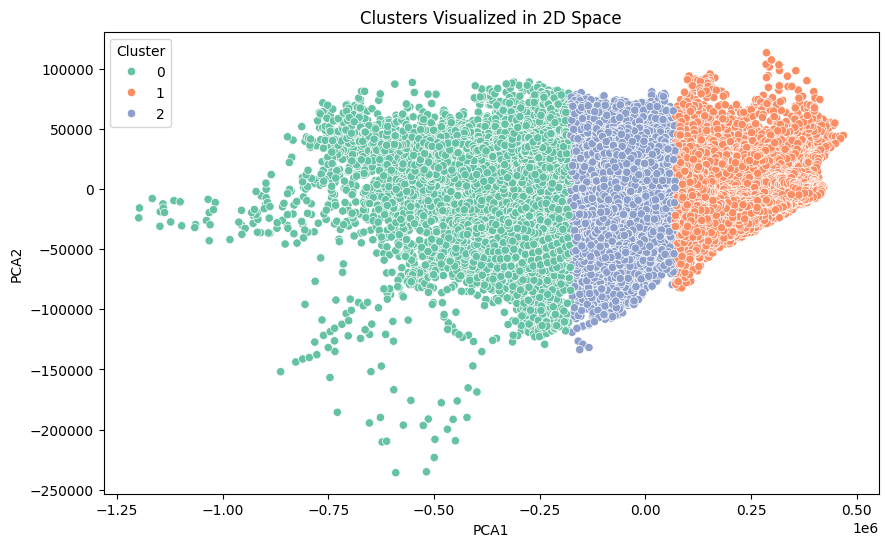

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(clustering_features)
merged_df['PCA1'] = reduced_data[:, 0]
merged_df['PCA2'] = reduced_data[:, 1]

# Plot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title("Clusters Visualized in 2D Space")
plt.show()


In [44]:
for cluster_id in merged_df['Cluster'].unique():
    cluster_data = merged_df[merged_df['Cluster'] == cluster_id]
    print(f"Cluster {cluster_id} Feature Means:")
    print(cluster_data[clustering_features.columns].mean())
    print("-" * 50)


Cluster 2 Feature Means:
ReflectedSW               181.572058
CloudOpticalDepth           8.016002
CloudTopTemperature       260.157064
DownwardSW                895.288637
TotalPrecipWater           26.563359
u10                        -1.766672
v10                         1.498252
t2m                       296.617615
sst                       297.573181
slhf                  -482169.531250
sshf                   -29233.734375
hcc                         0.173409
lcc                         0.245814
tcc                         0.413803
dtype: float64
--------------------------------------------------
Cluster 1 Feature Means:
ReflectedSW               191.006460
CloudOpticalDepth           7.598263
CloudTopTemperature       256.510559
DownwardSW                876.436405
TotalPrecipWater           27.479309
u10                         0.190023
v10                         2.840505
t2m                       296.470551
sst                       297.019592
slhf                  -256173.984

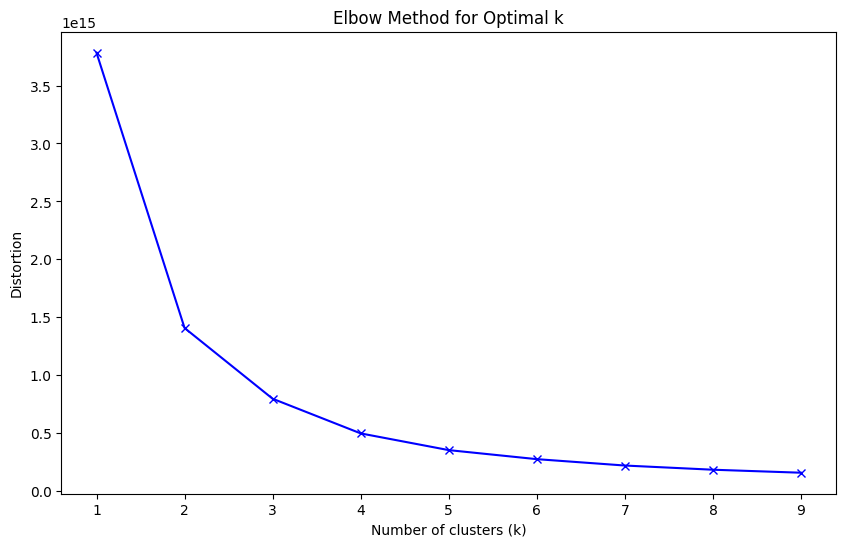

In [50]:

# Calculate distortions for a range of cluster numbers
distortions = []
K = range(1, 10)  # Adjust range as needed
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    distortions.append(kmeans.inertia_)

# Plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Method for Optimal k')
plt.show()



In [47]:

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)  # X_train should be your features before clustering



from sklearn.metrics import silhouette_score

for k in range(2, 5):  # Test different numbers of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score for {k} clusters: {score}")



Silhouette Score for 2 clusters: 0.3261570386164131
Silhouette Score for 3 clusters: 0.20558212423951275
Silhouette Score for 4 clusters: 0.19318866979199098


Try nonspherical clustering. 

In [48]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=10)  # Adjust eps and min_samples as needed
dbscan_labels = dbscan.fit_predict(X_scaled)

# Check number of clusters (ignoring noise, labeled as -1)
print(f"Number of clusters (excluding noise): {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")



Number of clusters (excluding noise): 174


Try hierarchal clustering 

GMM_Cluster
1    52900
0    36685
2     6724
Name: count, dtype: int64


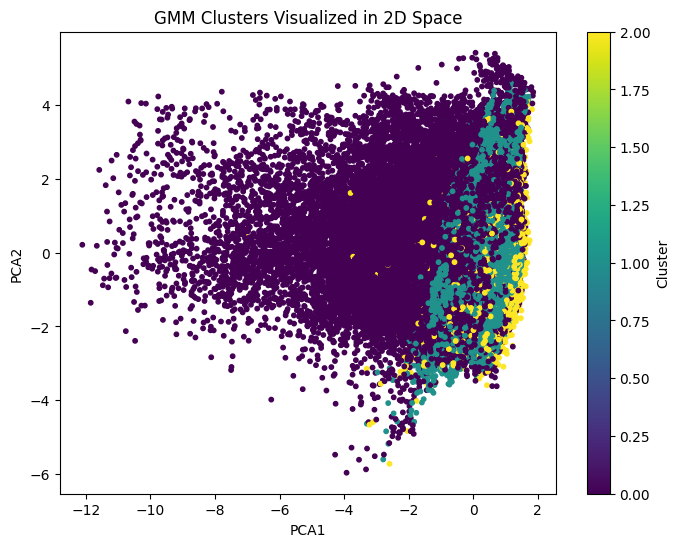

In [49]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=42)  # Adjust n_components
gmm_labels = gmm.fit_predict(X_scaled)
merged_df['GMM_Cluster'] = gmm_labels
print(merged_df['GMM_Cluster'].value_counts())
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA to reduce to 2 dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=gmm_labels, cmap='viridis', s=10)
plt.title("GMM Clusters Visualized in 2D Space")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.colorbar(label="Cluster")
plt.show()



If the clustering is poor, meaning there is overlap in the clusters and they are not distinct groups, try clustering after training the model instead. 

Now split the data to begin training. 

In [51]:
# Sort the data by time
merged_df = merged_df.sort_values(by='time')

# Split the data into training and testing based on time
train_data = merged_df[merged_df['time'] < '2020-04-21']  # First 19 days (April 2 to April 20)
test_data = merged_df[merged_df['time'] >= '2020-04-21']  # Last 10 days (April 21 to April 30)

# Further split the training data into training and validation sets
from sklearn.model_selection import train_test_split
train_val_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Print details of the splits
print("Training data time range:", train_data['time'].min(), "to", train_data['time'].max())
print("Training data size:", train_data.shape)
print("Validation data time range:", val_data['time'].min(), "to", val_data['time'].max())
print("Validation data size:", val_data.shape)
print("Test data time range:", test_data['time'].min(), "to", test_data['time'].max())
print("Test data size:", test_data.shape)


Training data time range: 2020-04-02 15:00:00 to 2020-04-20 15:00:00
Training data size: (63099, 21)
Validation data time range: 2020-04-02 15:00:00 to 2020-04-20 15:00:00
Validation data size: (6310, 21)
Test data time range: 2020-04-21 15:00:00 to 2020-04-30 15:00:00
Test data size: (33210, 21)


We need to scale the data now using our cluster feature. 

In [79]:
# Binarize the 'tcc' column: 0 for values < 0.5, 1 for values >= 0.5
merged_df['tcc'] = (merged_df['tcc'] >= 0.5).astype(int)


In [80]:
feature_columns = ['ReflectedSW', 'CloudOpticalDepth', 'CloudTopTemperature', 
                   'DownwardSW', 'TotalPrecipWater', 'sst', 'slhf', 'sshf', 'hcc', 'lcc']

# Split features for training, validation, and testing
X_train = train_data[feature_columns]
X_val = val_data[feature_columns]
X_test = test_data[feature_columns]


In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the training data and transform all sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [62]:
print("First few rows of scaled training data:")
print(X_train_scaled[:5])


First few rows of scaled training data:
[[-8.08425427e-02 -6.17718295e-02 -8.92631129e-02  1.13612740e-01
   6.35961161e-03  1.50013103e+00 -5.79083331e-01  8.80906623e-01
  -5.58289274e-01 -8.63935688e-01]
 [-6.68220027e-01 -6.17718295e-02 -8.92631129e-02  4.48367955e-01
  -1.26986559e+00 -3.39961663e-01  6.33725643e-02  1.89635071e+00
  -5.58289274e-01 -1.75893100e-01]
 [-6.39418077e-01 -6.17718295e-02 -8.92631129e-02  4.48236498e-01
   6.35961161e-03 -3.22096686e-01 -1.69039919e-03  2.15021173e+00
  -5.58289274e-01  8.53444095e-02]
 [-6.91171618e-01 -6.17718295e-02 -8.92631129e-02  4.48105041e-01
  -1.12199029e+00 -3.69074960e-01  2.93698095e-02  2.57542894e+00
  -5.58289274e-01  6.04695512e-01]
 [-6.90721579e-01 -6.17718295e-02 -8.92631129e-02  4.68088285e-01
  -1.06606102e+00 -3.90248267e-01  3.39471034e-02  2.63889420e+00
  -5.58289274e-01  4.23768687e-01]]


Perform some quick exploratory data analysis, like scatter plots and histrograms just to visualize the data. 

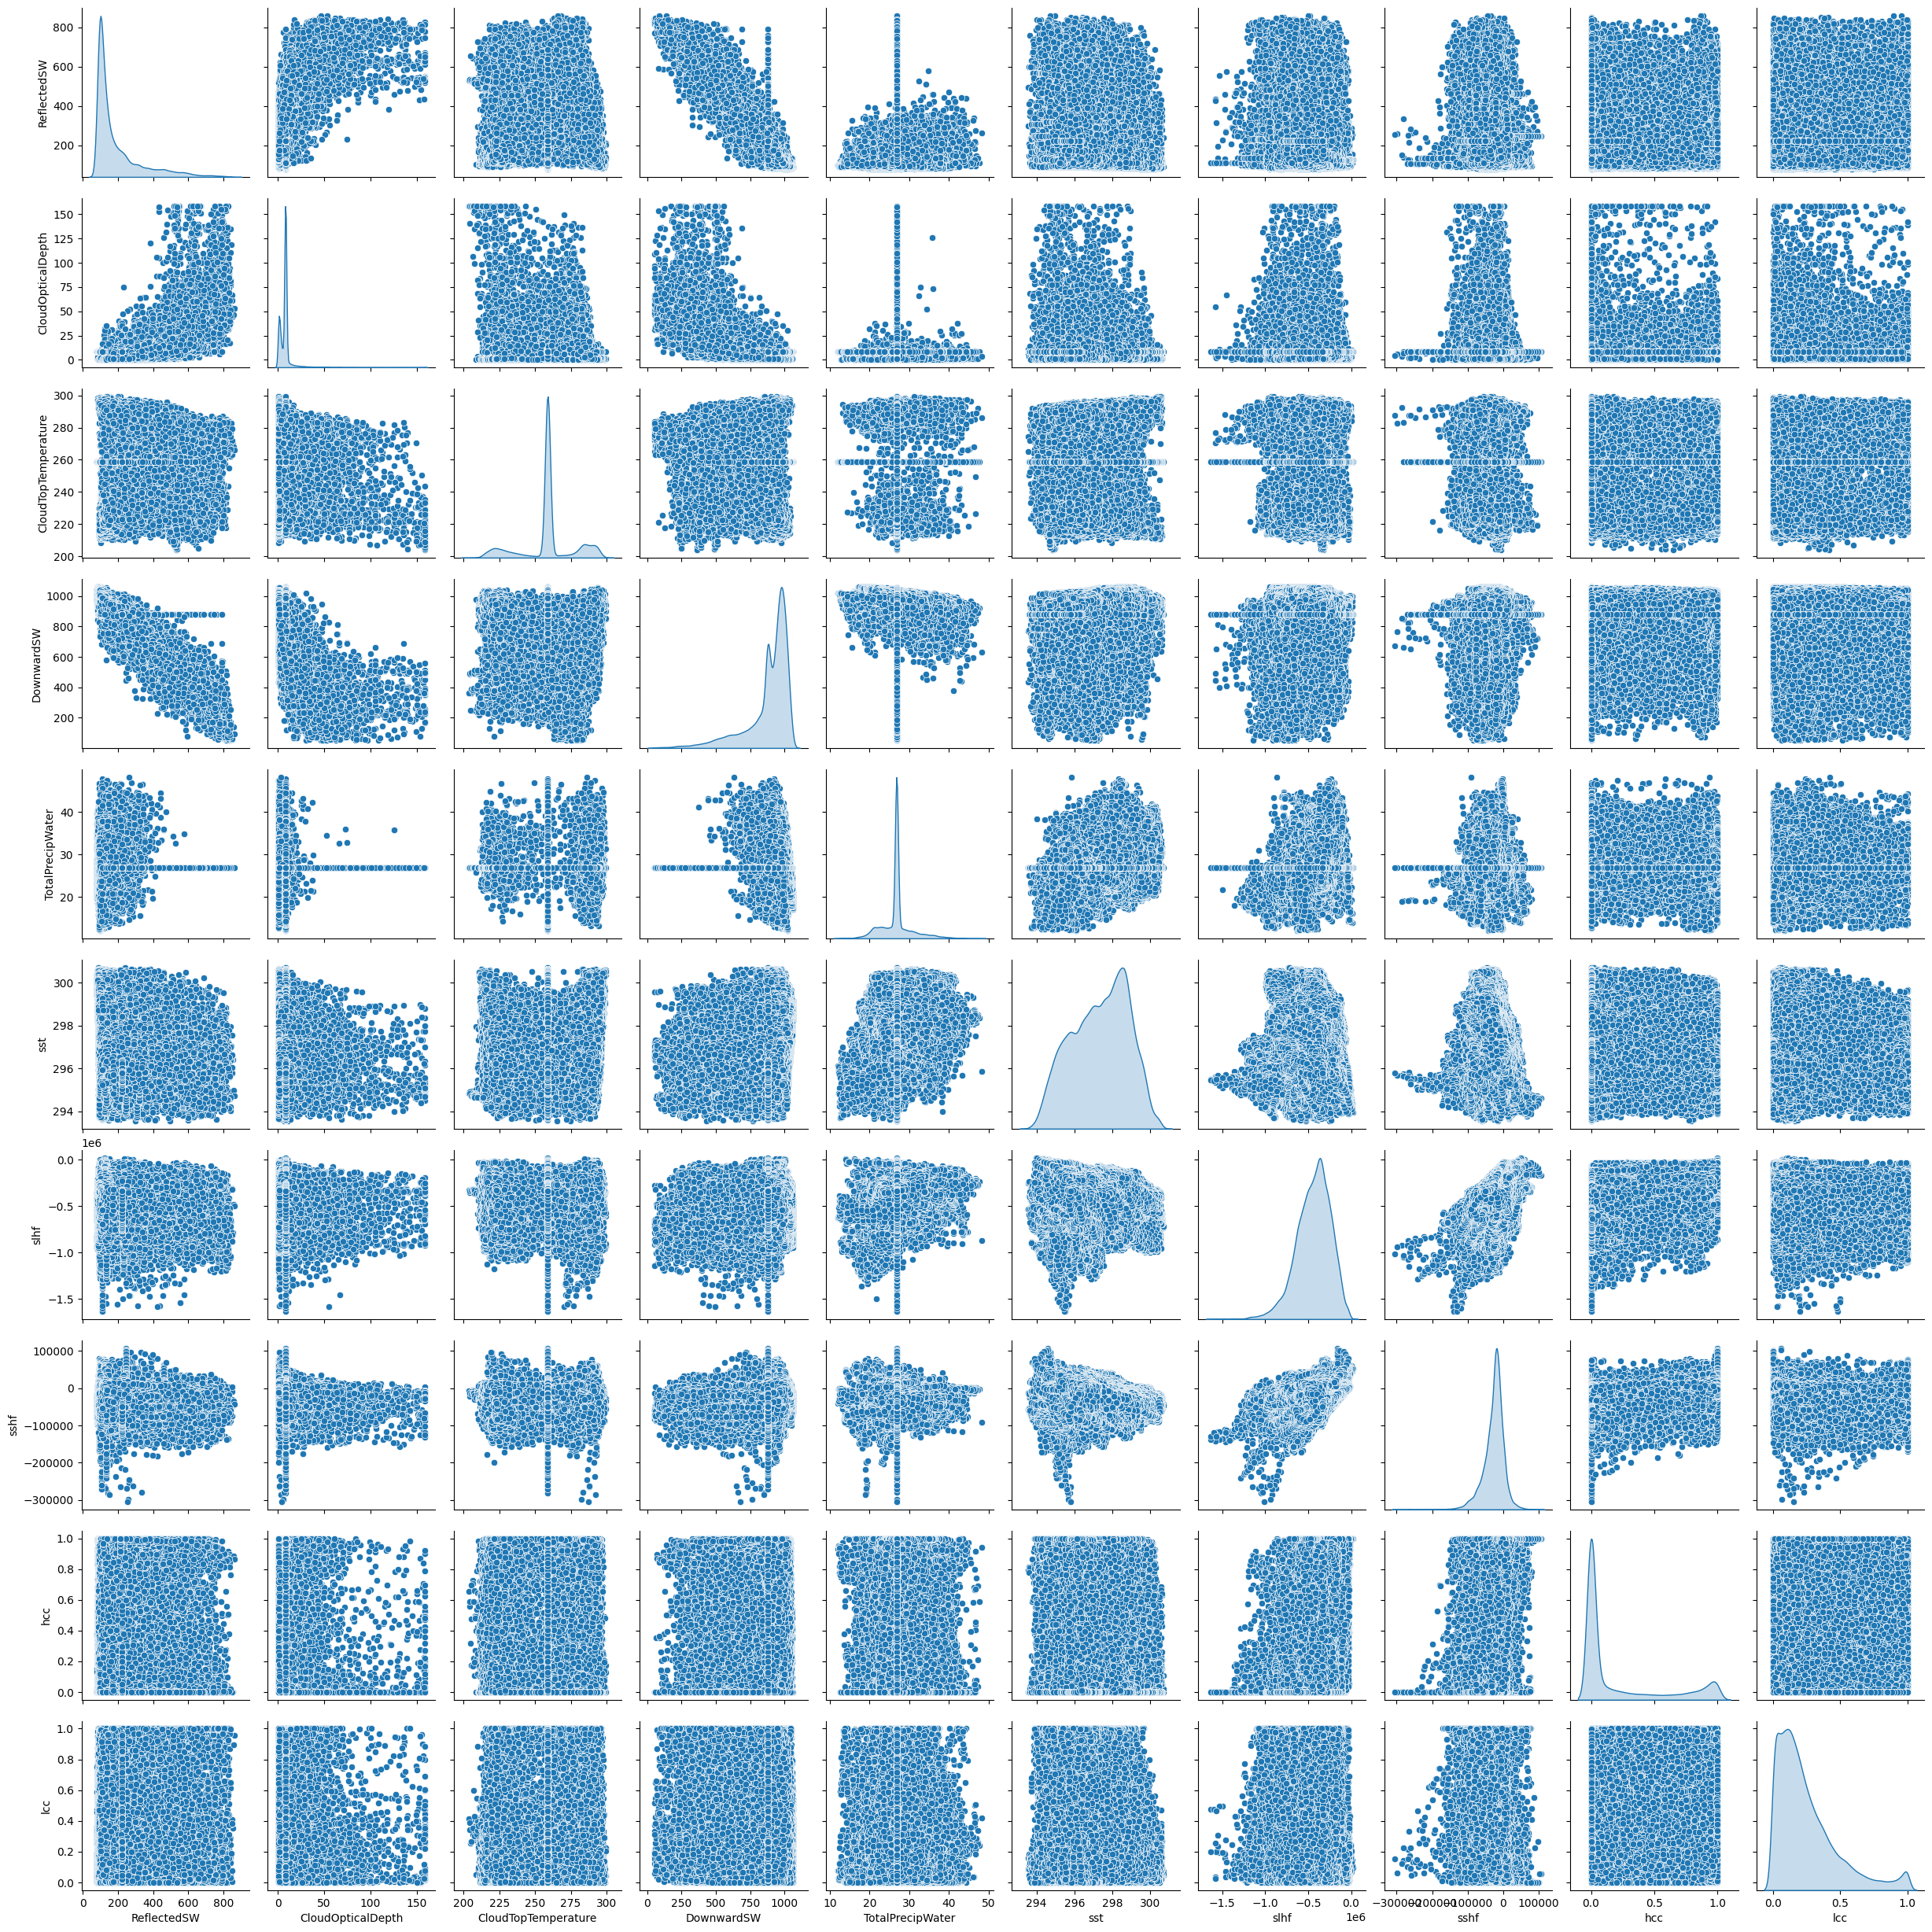

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(features, diag_kind='kde')
plt.show()


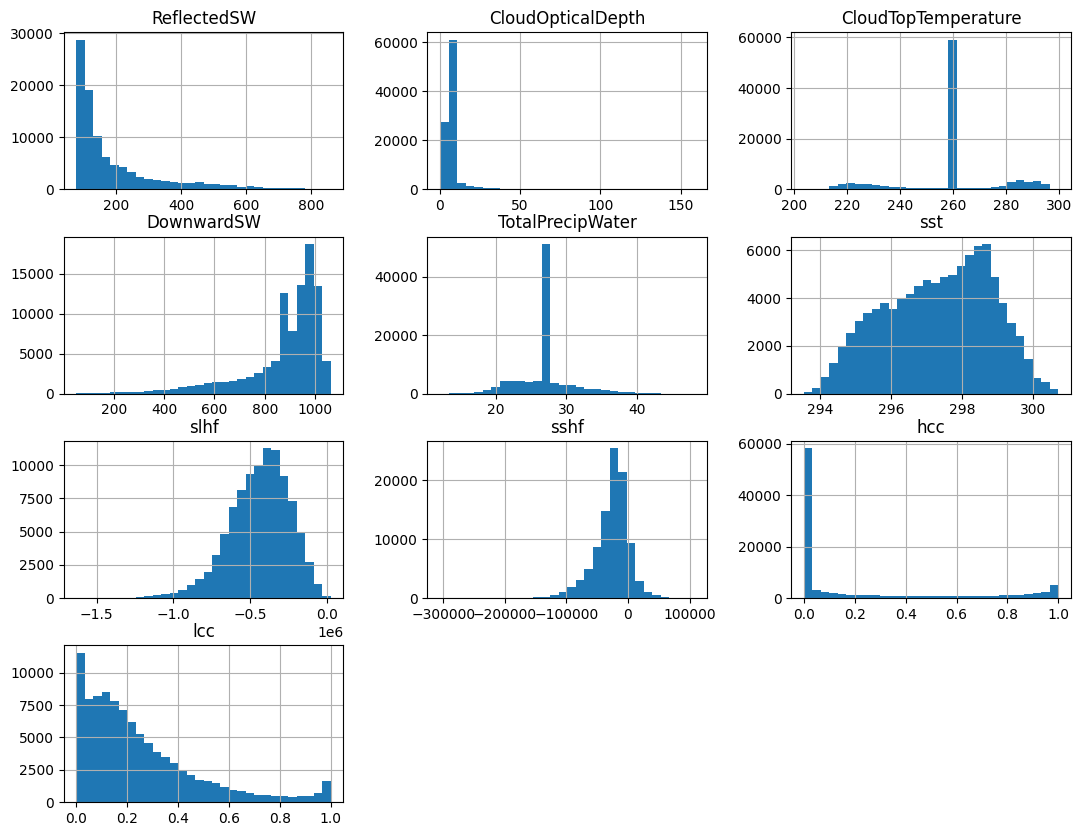

In [58]:
features.hist(figsize=(13, 10), bins=30)
plt.show()


Begin RandomForest

In [82]:
feature_columns = ['ReflectedSW', 'CloudOpticalDepth', 'CloudTopTemperature', 
                      'DownwardSW', 'TotalPrecipWater', 'sst', 'slhf', 'sshf', 'hcc', 'lcc'] 

X_train = train_data[feature_columns]
y_train = train_data['tcc']  # Target variable
X_val = val_data[feature_columns]
y_val = val_data['tcc']
X_test = test_data[feature_columns]
y_test = test_data['tcc']


In [69]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [70]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train_scaled, y_train)


RandomForestRegressor(random_state=42)

In [71]:
from sklearn.metrics import mean_squared_error, r2_score

# Validation
y_val_pred = rf.predict(X_val_scaled)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
print(f"Validation MSE: {val_mse}")
print(f"Validation R²: {val_r2}")

# Testing
y_test_pred = rf.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {test_mse}")
print(f"Test R²: {test_r2}")


Validation MSE: 0.0010530732551187118
Validation R²: 0.9885771628958283
Test MSE: 0.005064979984937643
Test R²: 0.9534349171886676


Show feature importance 

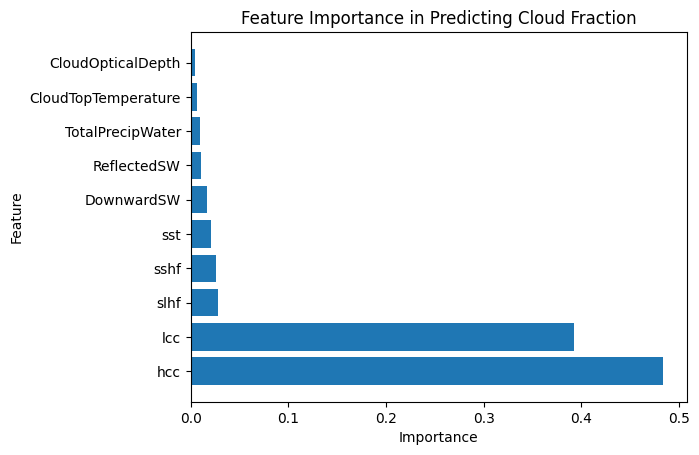

In [72]:

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Predicting Cloud Fraction")
plt.show()


Examine distributional shifts in the data over the month long time period. 

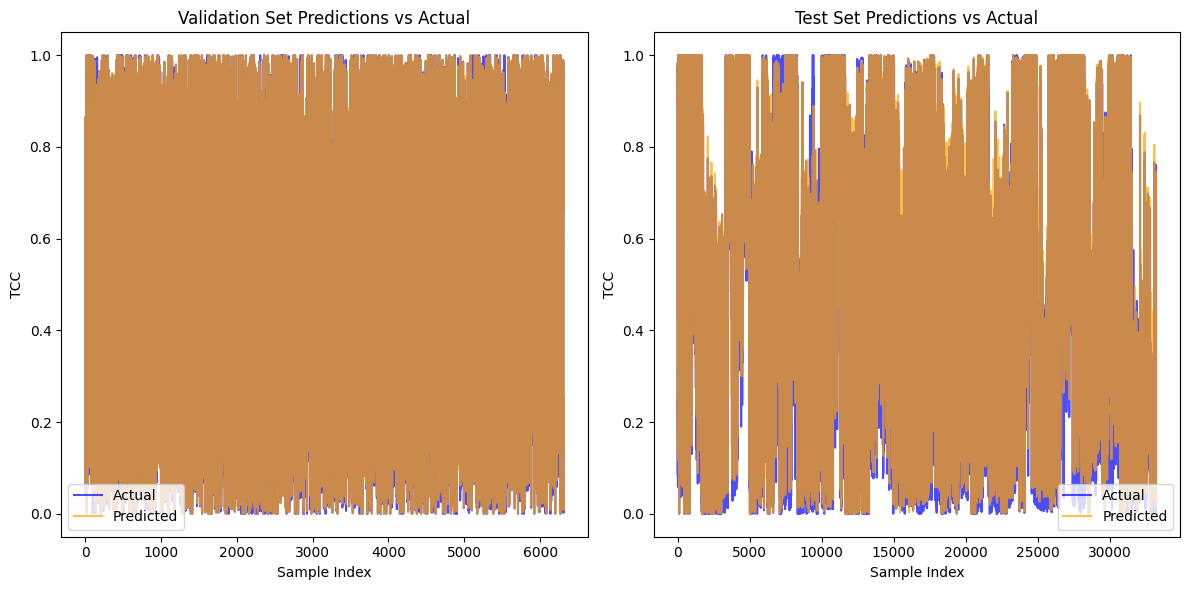

In [74]:

# Plot validation set predictions vs actual
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Two plots side by side
plt.plot(range(len(y_val)), y_val, label='Actual', color='blue', alpha=0.7)
plt.plot(range(len(y_val)), y_val_pred, label='Predicted', color='orange', alpha=0.7)
plt.title('Validation Set Predictions vs Actual')
plt.xlabel('Sample Index')
plt.ylabel('TCC')
plt.legend()

# Plot test set predictions vs actual
plt.subplot(1, 2, 2)
plt.plot(range(len(y_test)), y_test, label='Actual', color='blue', alpha=0.7)
plt.plot(range(len(y_test)), y_test_pred, label='Predicted', color='orange', alpha=0.7)
plt.title('Test Set Predictions vs Actual')
plt.xlabel('Sample Index')
plt.ylabel('TCC')
plt.legend()

plt.tight_layout()
plt.show()


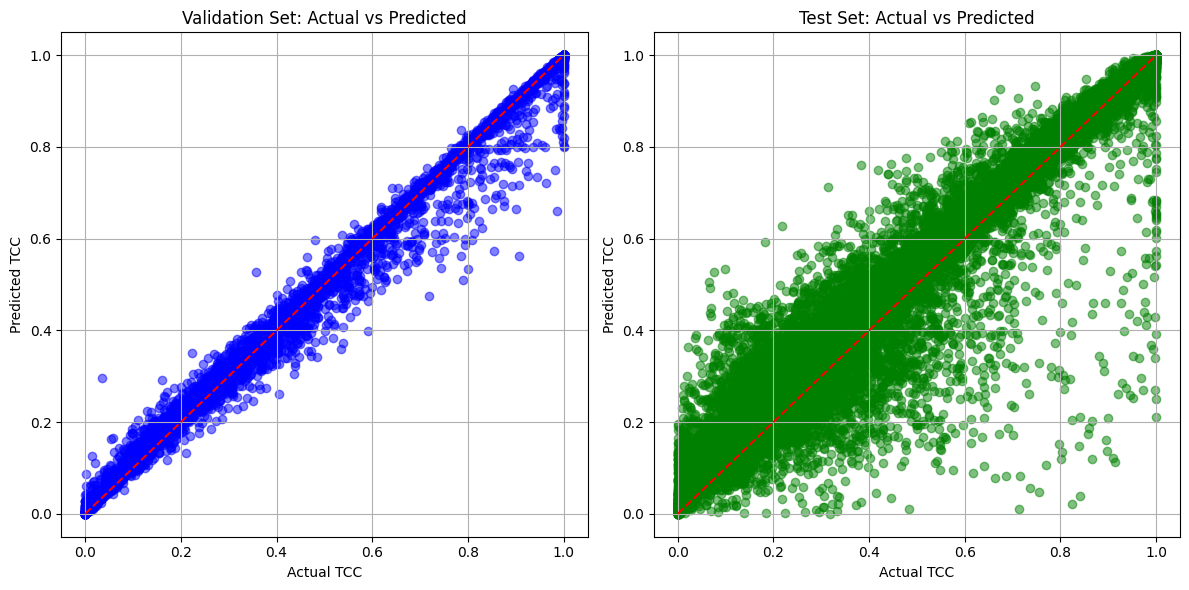

In [75]:

# Scatter plot for validation set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_val, y_val_pred, alpha=0.5, color='blue')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--')
plt.title('Validation Set: Actual vs Predicted')
plt.xlabel('Actual TCC')
plt.ylabel('Predicted TCC')
plt.grid(True)

# Scatter plot for test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_test_pred, alpha=0.5, color='green')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Test Set: Actual vs Predicted')
plt.xlabel('Actual TCC')
plt.ylabel('Predicted TCC')
plt.grid(True)

plt.tight_layout()
plt.show()


Tune the RandomForest model if the peaks for cloud fraction do not match for test and train. 

In [76]:
from sklearn.ensemble import RandomForestClassifier


In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Binarize 'tcc' column
train_data['tcc'] = (train_data['tcc'] >= 0.5).astype(int)
val_data['tcc'] = (val_data['tcc'] >= 0.5).astype(int)
test_data['tcc'] = (test_data['tcc'] >= 0.5).astype(int)

# Define features and target
feature_columns = ['ReflectedSW', 'CloudOpticalDepth', 'CloudTopTemperature', 
                   'DownwardSW', 'TotalPrecipWater', 'sst', 'slhf', 'sshf', 'hcc', 'lcc'] 

X_train = train_data[feature_columns]
y_train = train_data['tcc']
X_val = val_data[feature_columns]
y_val = val_data['tcc']
X_test = test_data[feature_columns]
y_test = test_data['tcc']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',  # Use accuracy or another classification metric
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Output best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# Train final model with best parameters
best_rf = grid_search.best_estimator_

# Validate the model
y_val_pred = best_rf.predict(X_val_scaled)
print("\nValidation Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report (Validation):\n", classification_report(y_val, y_val_pred))

# Test the model
y_test_pred = best_rf.predict(X_test_scaled)
print("\nTest Accuracy:", accuracy_score(y_test, y_test_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, y_test_pred))


C:\Users\kathe\AppData\Local\Temp\ipykernel_5468\3510454264.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['tcc'] = (train_data['tcc'] >= 0.5).astype(int)
C:\Users\kathe\AppData\Local\Temp\ipykernel_5468\3510454264.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['tcc'] = (test_data['tcc'] >= 0.5).astype(int)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Accuracy: 0.9300147387438787

Validation Accuracy: 0.948811410459588

Classification Report (Validation):
               precision    recall  f1-score   support

           0       0.93      1.00      0.96      4019
           1       1.00      0.86      0.92      2291

    accuracy                           0.95      6310
   macro avg       0.96      0.93      0.94      6310
weighted avg       0.95      0.95      0.95      6310


Test Accuracy: 0.9780487804878049

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     18826
           1       0.99      0.96      0.97     14384

    accuracy                           0.98     33210
   macro avg       0.98      0.98      0.98     33210
weighted avg       0.98      0.98      0.98     33210


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train_scaled, y_train)

# Output best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best CV R² Score:", grid_search.best_score_)

# Train final model with best parameters
best_rf = grid_search.best_estimator_
y_test_pred = best_rf.predict(X_test_scaled)


Fitting 3 folds for each of 81 candidates, totalling 243 fits


exception calling callback for <Future at 0x22c9fd4a8b0 state=finished raised BrokenProcessPool>
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\kathe\OneDrive\Documents\Anaconda\lib\site-packages\joblib\externals\loky\process_executor.py", line 407, in _process_worker
    call_item = call_queue.get(block=True, timeout=timeout)
  File "c:\Users\kathe\OneDrive\Documents\Anaconda\lib\multiprocessing\queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "c:\Users\kathe\OneDrive\Documents\Anaconda\lib\site-packages\sklearn\__init__.py", line 82, in <module>
    from .base import clone
  File "c:\Users\kathe\OneDrive\Documents\Anaconda\lib\site-packages\sklearn\base.py", line 17, in <module>
    from .utils import _IS_32BIT
  File "c:\Users\kathe\OneDrive\Documents\Anaconda\lib\site-packages\sklearn\utils\__init__.py", line 21, in <module>
    from scipy.sparse import issparse
  File "c:\Users\kathe\OneDri

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [87]:
# Predict on validation and test sets using the tuned model
y_val_pred = best_rf.predict(X_val_scaled)
y_test_pred = best_rf.predict(X_test_scaled)



In [88]:

# Validation set evaluation
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
print(f"Tuned Model Validation MSE: {val_mse}")
print(f"Tuned Model Validation R²: {val_r2}")

# Test set evaluation
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Tuned Model Test MSE: {test_mse}")
print(f"Tuned Model Test R²: {test_r2}")


Tuned Model Validation MSE: 0.05118858954041204
Tuned Model Validation R²: 0.7786452804004201
Tuned Model Test MSE: 0.02195121951219512
Tuned Model Test R²: 0.9105956448298196


Since the metrics are worse, the hyperparameter tuning over complicated the model. Do not use this. 

Try clustering, using 3 clusters before training the model. 

In [105]:
from sklearn.cluster import KMeans

# Perform clustering (as an example, KMeans)
kmeans = KMeans(n_clusters=3, random_state=42)
merged_df['Cluster'] = kmeans.fit_predict(merged_df[['ReflectedSW', 'CloudOpticalDepth', 'CloudTopTemperature', 
                                                      'DownwardSW', 'TotalPrecipWater', 'sst', 'slhf', 'sshf', 'hcc', 'lcc']])


In [106]:
feature_columns = ['ReflectedSW', 'CloudOpticalDepth', 'CloudTopTemperature', 
                   'DownwardSW', 'TotalPrecipWater', 'sst', 'slhf', 'sshf', 'hcc', 'lcc', 'Cluster']

# Split features for training, validation, and testing
X_train = train_data[feature_columns]
X_val = val_data[feature_columns]
X_test = test_data[feature_columns]

In [107]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit the scaler on the training data and transform all sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [108]:

train_data['tcc'] = (train_data['tcc'] >= 0.5).astype(int)
val_data['tcc'] = (val_data['tcc'] >= 0.5).astype(int)
test_data['tcc'] = (test_data['tcc'] >= 0.5).astype(int)

# Define features and target
feature_columns = ['ReflectedSW', 'CloudOpticalDepth', 'CloudTopTemperature', 
                   'DownwardSW', 'TotalPrecipWater', 'sst', 'slhf', 'sshf', 'hcc', 'lcc', 'Cluster'] 

X_train = train_data[feature_columns]
y_train = train_data['tcc']
X_val = val_data[feature_columns]
y_val = val_data['tcc']
X_test = test_data[feature_columns]
y_test = test_data['tcc']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)



rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train_scaled, y_train)

from sklearn.metrics import mean_squared_error, r2_score

# Validation
y_val_pred = rf.predict(X_val_scaled)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
print(f"Validation MSE: {val_mse}")
print(f"Validation R²: {val_r2}")

# Testing
y_test_pred = rf.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {test_mse}")
print(f"Test R²: {test_r2}")




C:\Users\kathe\AppData\Local\Temp\ipykernel_5468\3218094187.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['tcc'] = (train_data['tcc'] >= 0.5).astype(int)
C:\Users\kathe\AppData\Local\Temp\ipykernel_5468\3218094187.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['tcc'] = (test_data['tcc'] >= 0.5).astype(int)


Validation MSE: 0.0
Validation R²: 1.0
Test MSE: 0.022493224932249322
Test R²: 0.9083881298873461


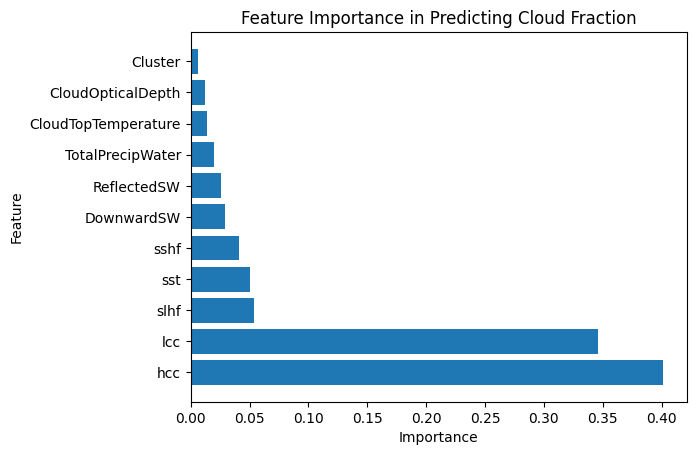

In [102]:
# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance in Predicting Cloud Fraction")
plt.show()

We need to try clustering again, but this time after we've already trained the model. 

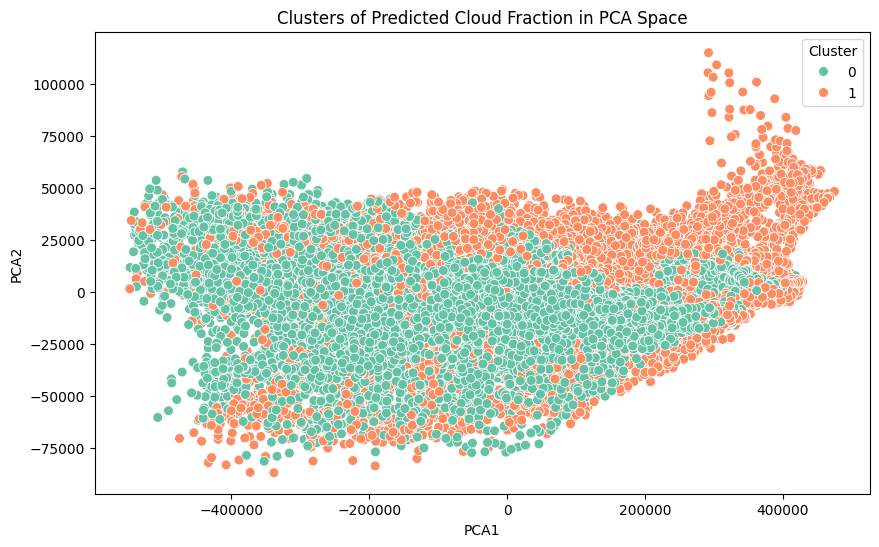

         PredictedCloudFraction  ReflectedSW  CloudOpticalDepth  \
Cluster                                                           
0                           0.0   158.136059           6.995032   
1                           1.0   185.580444           6.824373   

         CloudTopTemperature  DownwardSW  TotalPrecipWater         sst  \
Cluster                                                                  
0                 259.478626  930.096361         26.978521  298.352570   
1                 251.318969  894.700046         26.726357  297.099884   

                 slhf          sshf       hcc       lcc         PCA1  \
Cluster                                                                
0       -495569.65625 -28842.404297  0.038296  0.179671 -49070.63639   
1       -379822.93750 -18253.472656  0.658314  0.323248  67107.86468   

                PCA2  
Cluster               
0       -1462.284903  
1        1999.786932  


In [104]:
from sklearn.cluster import KMeans


# Step 1: Obtain predictions from the original Random Forest model
# Assuming `y_test_pred` and `X_test` are already available
predicted_results = pd.DataFrame({'PredictedCloudFraction': y_test_pred})
predicted_results = pd.concat([predicted_results, X_test.reset_index(drop=True)], axis=1)

# Step 2: Apply KMeans clustering
n_clusters = 2  # You can adjust this based on your data
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
predicted_results['Cluster'] = kmeans.fit_predict(predicted_results[['PredictedCloudFraction']])

# Step 3: Visualize clusters
pca = PCA(n_components=2)
pca_results = pca.fit_transform(predicted_results[['PredictedCloudFraction'] + list(X_test.columns)])
predicted_results['PCA1'] = pca_results[:, 0]
predicted_results['PCA2'] = pca_results[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=predicted_results, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=50)
plt.title('Clusters of Predicted Cloud Fraction in PCA Space')
plt.show()

# Step 4: Analyze clusters
cluster_summary = predicted_results.groupby('Cluster').mean()
print(cluster_summary)


Principal component analysis can reduce dimensionality. We can add this in and then retrain and run a linear regression model to see if it improves. 

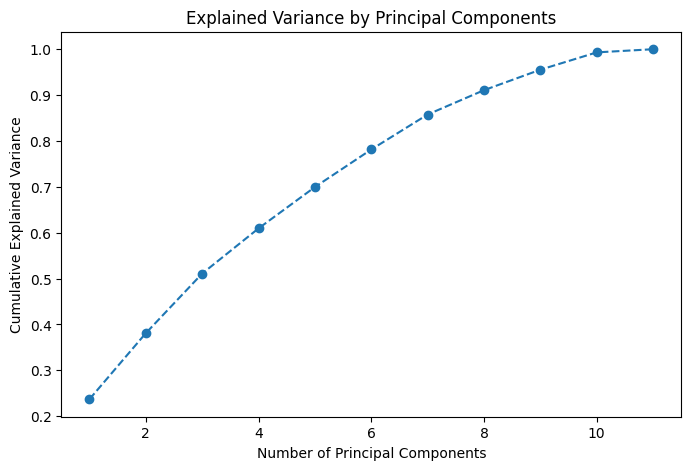

In [96]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA on the scaled feature set
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Plot explained variance ratio to choose the number of components
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.show()


In [109]:
n_components = 3
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [110]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Train the model
lr = LinearRegression()
lr.fit(X_train_pca, y_train)

# Predict on the test set
y_test_pca_pred = lr.predict(X_test_pca)

# Evaluate performance
test_mse_pca = mean_squared_error(y_test, y_test_pca_pred)
test_r2_pca = r2_score(y_test, y_test_pca_pred)

print(f"Linear Regression (PCA) Test MSE: {test_mse_pca}")
print(f"Linear Regression (PCA) Test R²: {test_r2_pca}")


Linear Regression (PCA) Test MSE: 0.15059056851258545
Linear Regression (PCA) Test R²: 0.386664933804754


In [111]:
components = pd.DataFrame(pca.components_, columns=feature_columns)
print(components)


   ReflectedSW  CloudOpticalDepth  CloudTopTemperature  DownwardSW  \
0    -0.545404          -0.415949             0.012912    0.552797   
1     0.196213           0.138268            -0.139591   -0.184013   
2     0.174054           0.162686             0.220899   -0.165889   

   TotalPrecipWater       sst      slhf      sshf       hcc       lcc  \
0          0.012553  0.159291  0.251848  0.271725 -0.013740 -0.138494   
1          0.063691 -0.270500  0.566456  0.482430  0.475178 -0.062991   
2          0.530570  0.606996  0.202622  0.042853 -0.247468 -0.225319   

    Cluster  
0  0.203980  
1  0.168629  
2  0.249143  


Try the PCA on the RandomForest. 

In [112]:
train_data['tcc'] = (train_data['tcc'] >= 0.5).astype(int)
val_data['tcc'] = (val_data['tcc'] >= 0.5).astype(int)
test_data['tcc'] = (test_data['tcc'] >= 0.5).astype(int)
# Apply PCA to the feature set
pca = PCA(n_components=3)  # Use 3 components as decided earlier
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Train a Random Forest on the PCA-transformed features
rf_pca = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf_pca.fit(X_train_pca, y_train)

# Make predictions
y_val_pred_pca = rf_pca.predict(X_val_pca)
y_test_pred_pca = rf_pca.predict(X_test_pca)

# Evaluate performance
val_mse_pca = mean_squared_error(y_val, y_val_pred_pca)
val_r2_pca = r2_score(y_val, y_val_pred_pca)
test_mse_pca = mean_squared_error(y_test, y_test_pred_pca)
test_r2_pca = r2_score(y_test, y_test_pred_pca)

print(f"PCA + Random Forest Validation MSE: {val_mse_pca}")
print(f"PCA + Random Forest Validation R²: {val_r2_pca}")
print(f"PCA + Random Forest Test MSE: {test_mse_pca}")
print(f"PCA + Random Forest Test R²: {test_r2_pca}")


C:\Users\kathe\AppData\Local\Temp\ipykernel_5468\3372214306.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['tcc'] = (train_data['tcc'] >= 0.5).astype(int)
C:\Users\kathe\AppData\Local\Temp\ipykernel_5468\3372214306.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['tcc'] = (test_data['tcc'] >= 0.5).astype(int)


PCA + Random Forest Validation MSE: 0.1988906497622821
PCA + Random Forest Validation R²: 0.13993754458986785
PCA + Random Forest Test MSE: 0.21906052393857273
PCA + Random Forest Test R²: 0.10779604408359089


RandomForest with PCA is worse than RandomForest without PCA. 

Let's try creating a U net 

In [113]:
import numpy as np

feature_columns = ['ReflectedSW', 'CloudOpticalDepth', 'CloudTopTemperature', 
                   'DownwardSW', 'TotalPrecipWater', 'sst', 'slhf', 'sshf', 'hcc', 'lcc']

# Assume merged_df contains 'latitude', 'longitude', and 'time'
data_grid = merged_df.pivot_table(index=['latitude', 'longitude'], 
                                  columns='time', 
                                  values=feature_columns)



In [114]:

# Example dimensions
latitudes = merged_df['latitude'].unique()
longitudes = merged_df['longitude'].unique()
time_steps = merged_df['time'].unique()

# Initialize empty grid
tcc_grid = np.empty((len(latitudes), len(longitudes), len(time_steps)))

# Populate the grid
for t, time in enumerate(time_steps):
    time_slice = merged_df[merged_df['time'] == time]
    for i, lat in enumerate(latitudes):
        for j, lon in enumerate(longitudes):
            value = time_slice[
                (time_slice['latitude'] == lat) & (time_slice['longitude'] == lon)
            ]['tcc']
            tcc_grid[i, j, t] = value.values[0] if not value.empty else np.nan


In [116]:
print("tcc_grid type:", type(tcc_grid))
print("tcc_grid shape:", tcc_grid.shape)


tcc_grid type: <class 'numpy.ndarray'>
tcc_grid shape: (41, 81, 29)


In [117]:
tcc_grid = np.where(tcc_grid < 0.5, 0, 1)  # Binarize the grid
print("Unique values in tcc_grid after binarization:", np.unique(tcc_grid))


Unique values in tcc_grid after binarization: [0 1]


In [118]:
train_data = tcc_grid[:, :, :19]  # First 19 days
test_data = tcc_grid[:, :, 19:]  # Last 10 days
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (41, 81, 19)
Test data shape: (41, 81, 10)


In [119]:
import numpy as np

# Reshape data for U-Net
X_train = train_data.transpose(2, 0, 1)[..., np.newaxis]  # Shape: (19, 41, 81, 1)
X_test = test_data.transpose(2, 0, 1)[..., np.newaxis]    # Shape: (10, 41, 81, 1)

# Labels are the same
y_train = X_train.copy()  # Use X_train as labels for supervised learning
y_test = X_test.copy()    # Use X_test as labels for supervised learning

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (19, 41, 81, 1)
X_test shape: (10, 41, 81, 1)


In [123]:
import tensorflow as tf

# Resize function
def resize_grid(data, target_shape):
    return tf.image.resize(data, target_shape, method='bilinear').numpy()

# Define the target shape
target_shape = (40, 80)  # Resize to dimensions divisible by 16

# Resize training and test data
X_train_resized = np.array([resize_grid(x, target_shape) for x in X_train])
X_test_resized = np.array([resize_grid(x, target_shape) for x in X_test])

# Expand dimensions for channels
X_train_resized = X_train_resized[..., np.newaxis]
X_test_resized = X_test_resized[..., np.newaxis]

# Resize labels (if needed)
y_train_resized = np.array([resize_grid(y, target_shape) for y in y_train])
y_test_resized = np.array([resize_grid(y, target_shape) for y in y_test])

print("Resized X_train shape:", X_train_resized.shape)
print("Resized X_test shape:", X_test_resized.shape)


Resized X_train shape: (19, 40, 80, 1, 1)
Resized X_test shape: (10, 40, 80, 1, 1)


In [124]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

# Define U-Net architecture
def build_unet(input_shape):
    inputs = Input(input_shape)

    # Downsampling path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    # Upsampling path
    u4 = UpSampling2D((2, 2))(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u5 = UpSampling2D((2, 2))(c4)
    u5 = concatenate([u5, c1])
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs, outputs)
    return model

# Build the U-Net model
input_shape = (40, 80, 1)  # Adjust based on your resized grid
unet_model = build_unet(input_shape)
unet_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 40, 80, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 40, 80,    │        640 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 40, 80,    │     36,928 │ conv2d_16[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 20, 40,    │          0 │ conv2d_17[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 20, 40,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 20, 40,    │    147,584 │ conv2d_18[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 10, 20,    │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 10, 20,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 10, 20,    │    590,080 │ conv2d_20[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_6     │ (None, 20, 40,    │          0 │ conv2d_21[0][0]   │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 20, 40,    │          0 │ up_sampling2d_6[… │
│ (Concatenate)       │ 384)              │            │ conv2d_19[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 20, 40,    │    442,496 │ concatenate_4[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 20, 40,    │    147,584 │ conv2d_22[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_7     │ (None, 40, 80,    │          0 │ conv2d_23[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 40, 80,    │          0 │ up_sampling2d_7[… │
│ (Concatenate)       │ 192)              │            │ conv2d_17[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 40, 80,    │    110,656 │ concatenate_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 40, 80,    │     36,928 │ conv2d_24[0][0] 

 Total params: 1,881,985 (7.18 MB)

 Trainable params: 1,881,985 (7.18 MB)

 Non-trainable params: 0 (0.00 B)

In [125]:
# Compile the U-Net model
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [126]:
# Train the U-Net model
history = unet_model.fit(
    X_train_resized, y_train_resized,
    validation_data=(X_test_resized, y_test_resized),
    batch_size=16,
    epochs=20,  # Adjust epochs as needed
    verbose=1
)


Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.4350 - loss: 0.6952 - val_accuracy: 0.4316 - val_loss: 0.6570
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 511ms/step - accuracy: 0.4462 - loss: 0.6609 - val_accuracy: 0.3981 - val_loss: 1.0754
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step - accuracy: 0.4787 - loss: 0.9419 - val_accuracy: 0.5442 - val_loss: 0.5975
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step - accuracy: 0.5335 - loss: 0.6229 - val_accuracy: 0.5268 - val_loss: 0.5914
Epoch 5/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 479ms/step - accuracy: 0.5215 - loss: 0.6212 - val_accuracy: 0.6187 - val_loss: 0.5574
Epoch 6/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step - accuracy: 0.6236 - loss: 0.5868 - val_accuracy: 0.6825 - val_loss: 0.4901
Epoch 7/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 483ms/step - accuracy: 0.6851 - loss: 0.5060 - val_accuracy: 0.6521 - val_loss: 0.4301
Epoch 8/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 473ms/step - accuracy: 0.6491 - loss: 0.4406 - val_accuracy: 0.6664 - val_loss: 0.

In [127]:
# Evaluate on the test set
test_loss, test_accuracy = unet_model.evaluate(X_test_resized, y_test_resized)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.6886 - loss: 0.2253
Test Loss: 0.22530822455883026
Test Accuracy: 0.6886249780654907


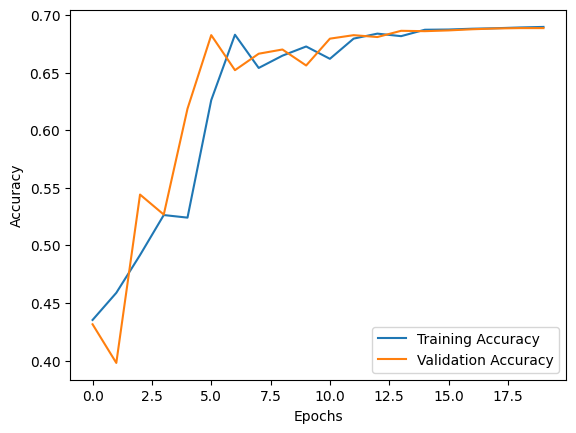

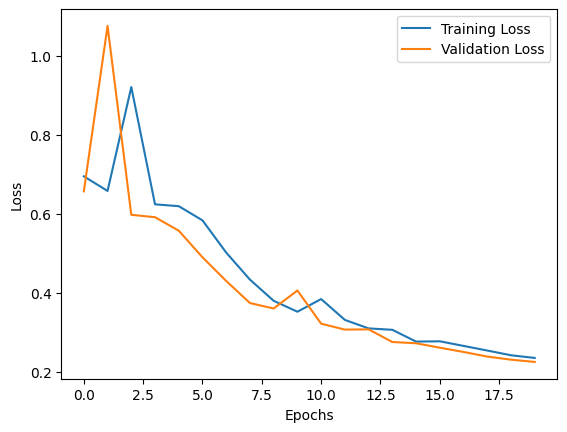

In [128]:

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


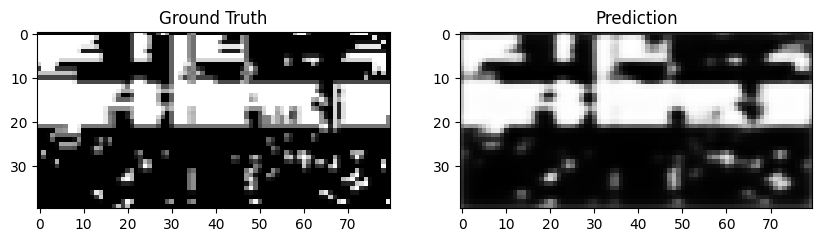

In [129]:
# Make predictions
y_pred = unet_model.predict(X_test_resized)

# Visualize predictions
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Ground Truth")
plt.imshow(y_test_resized[0, :, :, 0], cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Prediction")
plt.imshow(y_pred[0, :, :, 0], cmap='gray')
plt.show()
